In [4]:
import tweepy

# Replace the API_KEY and API_SECRET with your application's key and secret.
auth = tweepy.AppAuthHandler('irNBsBncAReExSxJ0YwOg8sar','UXaU2ykLNqBJGzeox8TvkCxNO7QQrgwbok5s8z7NexfeWpqeL0')

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)




In [5]:

import tweepy
import sys
import jsonpickle
import os

searchQuery = 'elections'  # this is what we're searching for
maxTweets = 1000 
tweetsPerQry = 100  
fName = 'tweets1.txt' # We'll store the tweets in a text file.


sinceId = None
# If results only below a specific ID are, set max_id to that ID.
# else default to no upper limit, start from the most recent tweet matching the search query.
max_id = -1

tweetCount = 0
print("Downloading max {0} tweets".format(maxTweets))
with open(fName, 'w') as f:
    while tweetCount < maxTweets:
        try:
            if (max_id <= 0):
                if (not sinceId):
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry)
                else:
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                            since_id=sinceId)
            else:
                if (not sinceId):
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                            max_id=str(max_id - 1))
                else:
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                            max_id=str(max_id - 1),
                                            since_id=sinceId)
            if not new_tweets:
                print("No more tweets found")
                break
            for tweet in new_tweets:
                f.write(jsonpickle.encode(tweet._json, unpicklable=False) +
                        '\n')
            tweetCount += len(new_tweets)
            print("Downloaded {0} tweets".format(tweetCount))
            max_id = new_tweets[-1].id
        except tweepy.TweepError as e:
            # Exit if any error
            print("some error : " + str(e))
            break

print ("Downloaded {0} tweets, Saved to {1}".format(tweetCount, fName))


Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 300 tweets
Downloaded 400 tweets
Downloaded 500 tweets
Downloaded 600 tweets
Downloaded 700 tweets
Downloaded 800 tweets
Downloaded 900 tweets
Downloaded 1000 tweets
Downloaded 1000 tweets, Saved to tweets1.txt


In [6]:
#load tweets 

import json

filename = 'tweets1.txt'

tweet_list = []

with open(filename, 'r') as fopen:
    # each line corresponds to a tweet
    for line in fopen:
        if line != '\n':
            tweet_list.append(json.loads(line))

In [7]:
def getTweetID(tweet):
    """ If properly included, get the ID of the tweet """
    return tweet.get('id')
    
def getUserIDandScreenName(tweet):
    """ If properly included, get the tweet 
        user ID and Screen Name """
    user = tweet.get('user')
    if user is not None:
        uid = user.get('id')
        screen_name = user.get('screen_name')
        return uid, screen_name
    else:
        return (None, None)

def getRetweetedUserIDandSreenName(tweet):
    """ If properly included, get the retweet 
        source user ID and Screen Name"""
    
    retweet = tweet.get('retweeted_status')
    if retweet is not None:
        return getUserIDandScreenName(retweet)
    else:
        return (None, None)
    
def getRepliedUserIDandScreenName(tweet):
    """ If properly included, get the ID and Screen Name 
        of the user the tweet replies to """
    
    reply_id = tweet.get('in_reply_to_user_id')
    reply_screenname = tweet.get('in_reply_to_screen_name')
    return reply_id, reply_screenname
    
def getUserMentionsIDandScreenName(tweet):
    """ If properly included, return a list of IDs and Screen Names tuple
        of all user mentions, including retweeted and replied users """
        
    mentions = []
    entities = tweet.get('entities')
    if entities is not None:
        user_mentions = entities.get('user_mentions')
        for mention in user_mentions:
            mention_id = mention.get('id')
            screen_name = mention.get('screen_name')
            mentions.append((mention_id, screen_name))
    
    return mentions

    
def getQuotedUserIDandScreenName(tweet):
    """ If properly included, get the ID of the user the tweet is quoting"""
    
    quoted_status = tweet.get('quoted_status')
    
    if quoted_status is not None:
        return getUserIDandScreenName(quoted_status)
    else:
        return (None, None)
    
def getAllInteractions(tweet):
    """ Get all the interactions from this tweet
    
        returns : (tweeter_id, tweeter_screenname), list of (interacting_id, interacting_screenname)
    """
    
    # Get the tweeter
    tweeter = getUserIDandScreenName(tweet)
    
    if tweeter[0] is None:
        return (None, None), []
    
    interacting_users = set()
    
    # Add person they're replying to
    interacting_users.add(getRepliedUserIDandScreenName(tweet))
    
    # Add person they retweeted
    interacting_users.add(getRetweetedUserIDandSreenName(tweet))
    
    # Add person they quoted
    interacting_users.add(getQuotedUserIDandScreenName(tweet))
    
    # Add mentions
    interacting_users.update(getUserMentionsIDandScreenName(tweet))
  
    
    interacting_users.discard(tweeter)
    interacting_users.discard((None,None))
    
    # Return our tweeter and their influencers
    return tweeter, list(interacting_users)

In [8]:
import networkx as nx

G = nx.DiGraph()

# loop over all the tweets and add edges if the tweet include some interactions
for tweet in tweet_list:
    # find all influencers in the tweet
    tweeter, interactions = getAllInteractions(tweet)
    tweeter_id, tweeter_name = tweeter
    tweet_id = getTweetID(tweet)
    
    # add an edge to the Graph for each influencer
    for interaction in interactions:
        interact_id, interact_name = interaction
        
        # add edges between the two user ids
        # this will create new nodes if the nodes are not already in the network
        # we also add an attribute the to edge equal to the id of the tweet
        G.add_edge(tweeter_id, interact_id, tweet_id=tweet_id)
        
        # add name as a property to each node
        # with networkX each node is a dictionary
        G.node[tweeter_id]['name'] = tweeter_name
        G.node[interact_id]['name'] = interact_name

In [9]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [10]:
# this returns a list of set of nodes belonging to the 
# different (weakly) connected components
components = list(nx.weakly_connected_components(G))

# sort the component according to their size
components = list(sorted(components, key=lambda x:len(x), reverse=True))

In [11]:
comp_sizes = []
for comp in components:
    comp_sizes.append(len(comp))

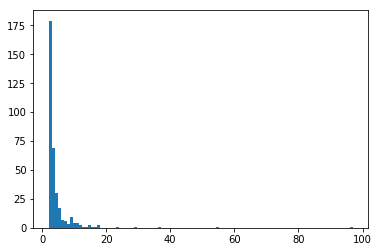

In [12]:

# plot the histogram of component sizes
hist = plt.hist(comp_sizes, bins=100)


Text(0,0.5,'number of components')

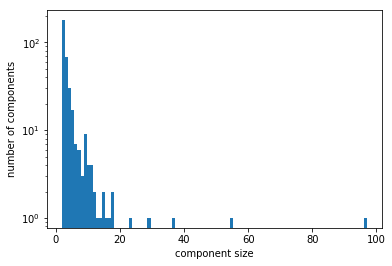

In [13]:
# histogram with logarithmic y scale
hist = plt.hist(comp_sizes, bins=100, log=True)
plt.xlabel('component size')
plt.ylabel('number of components')

In [14]:
# finding the largest component
largest_comp = components[0]
LCC = G.subgraph(largest_comp)

In [15]:
G.number_of_nodes()
LCC.number_of_nodes()
degrees = nx.degree(LCC)
len(degrees)

97

In [16]:
import random

def getGCsize(G):
    """ returns the size of the largest component of G"""
        
    comps = nx.connected_components(G)
    return max([len(comp) for comp in comps])

In [17]:
# high degree attack
LCCundirected = nx.Graph(LCC)

node_deg_dict = dict(nx.degree(LCCundirected))
nodes_sorted = sorted(node_deg_dict, key=node_deg_dict.get)

hd_attack_GC_sizes = []

while len(nodes_sorted) > 1:
    
    hd_attack_GC_sizes.append(getGCsize(LCCundirected))
    
    #remove node according to their degree
    node = nodes_sorted.pop()
    LCCundirected.remove_node(node)

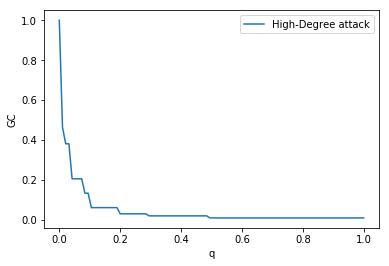

In [18]:

hd_attack_GC_sizes = np.array(hd_attack_GC_sizes)
GC_hd = hd_attack_GC_sizes/hd_attack_GC_sizes[0]
q = np.linspace(0,1,num=GC_hd.size)

plt.plot(q,GC_hd, label='High-Degree attack')
plt.xlabel('q')
plt.ylabel('GC')
plt.legend()

In [19]:

nx.write_graphml(LCC, 'twitter_lcc2.graphml')

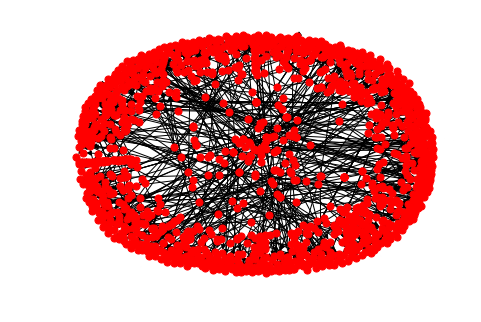

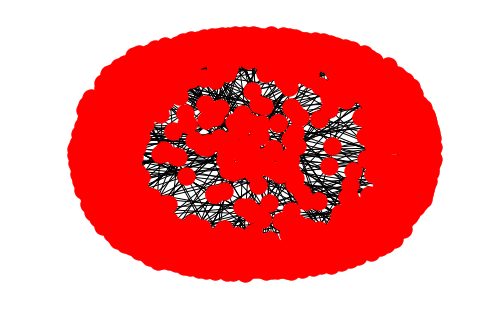

In [20]:
nx.draw(G, node_size=50)
plt.show()

pos_spring = nx.spring_layout(G)
pos_fr = nx.fruchterman_reingold_layout(G)
#print(pos_fr)
nx.draw(G, pos=pos_fr)


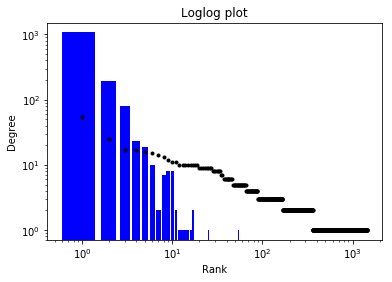

In [21]:
import collections
import matplotlib.pyplot as plt

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

plt.loglog(range(1,G.order()+1),degree_sequence,'k.')
plt.xlabel("Rank")
plt.ylabel("Degree")
plt.title("Loglog plot")
plt.show()

In [22]:
r=nx.degree_assortativity_coefficient(G)
print("Degree assortativity:\n")
print(r)

Degree assortativity:

-0.2233442570107972


In [23]:
sp=nx.all_pairs_dijkstra_path(G)
print("Shortest paths\n")
pair=nx.all_pairs_shortest_path(G)
print(*(n for n in pair), sep='\n')

Shortest paths

(50854399, {50854399: [50854399], 462104542: [50854399, 462104542]})
(462104542, {462104542: [462104542]})
(4794724303, {4794724303: [4794724303], 4690856839: [4794724303, 4690856839]})
(4690856839, {4690856839: [4690856839]})
(240392587, {240392587: [240392587], 751852736: [240392587, 751852736]})
(751852736, {751852736: [751852736]})
(268845578, {268845578: [268845578], 2301612055: [268845578, 2301612055], 913615578: [268845578, 913615578], 951834552783294465: [268845578, 951834552783294465], 2875700829: [268845578, 2875700829], 499871659: [268845578, 499871659], 973302870874324992: [268845578, 973302870874324992], 808695289884327936: [268845578, 808695289884327936], 963156850609983488: [268845578, 963156850609983488], 826256205584535557: [268845578, 826256205584535557], 1002398924836167680: [268845578, 1002398924836167680]})
(2301612055, {2301612055: [2301612055]})
(913615578, {913615578: [913615578]})
(951834552783294465, {951834552783294465: [951834552783294465]})


(4850975532, {4850975532: [4850975532], 757725064695603200: [4850975532, 757725064695603200]})
(757725064695603200, {757725064695603200: [757725064695603200]})
(892969022362451968, {892969022362451968: [892969022362451968], 1049065439836422145: [892969022362451968, 1049065439836422145], 122084073: [892969022362451968, 122084073], 3221601061: [892969022362451968, 3221601061]})
(1028612277921083392, {1028612277921083392: [1028612277921083392], 2886122614: [1028612277921083392, 2886122614]})
(2886122614, {2886122614: [2886122614]})
(381562074, {381562074: [381562074], 294082746: [381562074, 294082746]})
(3336484006, {3336484006: [3336484006], 38395124: [3336484006, 38395124]})
(38395124, {38395124: [38395124]})
(315461934, {315461934: [315461934], 462104542: [315461934, 462104542]})
(1565400392, {1565400392: [1565400392], 288778951: [1565400392, 288778951]})
(1036029202238267394, {1036029202238267394: [1036029202238267394], 1084105231: [1036029202238267394, 1084105231]})
(1084105231, {108

(1065869268, {1065869268: [1065869268]})
(1026897289024077826, {1026897289024077826: [1026897289024077826], 3492889282: [1026897289024077826, 3492889282], 726748106: [1026897289024077826, 726748106]})
(3492889282, {3492889282: [3492889282]})
(726748106, {726748106: [726748106]})
(433056695, {433056695: [433056695], 15537302: [433056695, 15537302]})
(597822214, {597822214: [597822214], 1589434802: [597822214, 1589434802], 30835371: [597822214, 30835371]})
(1589434802, {1589434802: [1589434802]})
(30835371, {30835371: [30835371]})
(200005497, {200005497: [200005497], 21612122: [200005497, 21612122], 24431892: [200005497, 24431892], 19087651: [200005497, 19087651]})
(19087651, {19087651: [19087651]})
(20698136, {20698136: [20698136], 1965420800: [20698136, 1965420800]})
(1965420800, {1965420800: [1965420800]})
(723555882970304512, {723555882970304512: [723555882970304512], 1869400670: [723555882970304512, 1869400670]})
(1869400670, {1869400670: [1869400670]})
(209609597, {209609597: [2096

In [24]:
from heapq import nlargest
eb=nx.edge_betweenness_centrality(G)
ebl=sorted(eb.items(),
key=lambda i: i[1],
reverse=True)[:5]
s='\n Top 5 edge betweenness centrality :\n'
print (s)
for item in ebl:
    s=repr(item) + ','
    print (s)




 Top 5 edge betweenness centrality :

((1239565723, 1994321), 1.119263894201337e-05),
((58959991, 786612252719718400), 3.4064553301779822e-06),
((1689001136, 4829144355), 2.9198188544382705e-06),
((739409715445239808, 3049824545), 2.4331823786985587e-06),
((4829144355, 1239565723), 1.946545902958847e-06),


In [25]:
G2 = G.to_undirected()

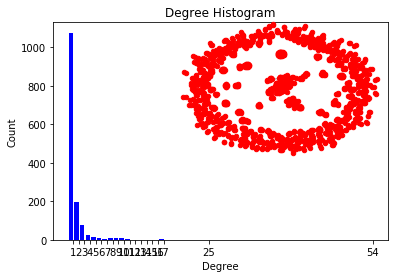

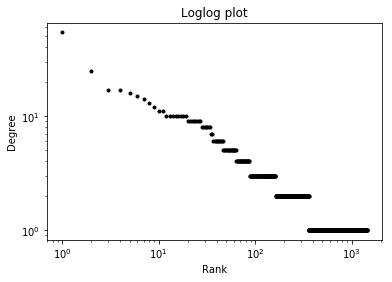

In [26]:
import collections
import matplotlib.pyplot as plt

degree_sequence = sorted([d for n, d in G2.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = sorted(nx.connected_component_subgraphs(G2), key=len, reverse=True)[0]
pos = nx.spring_layout(G2)
plt.axis('off')
nx.draw_networkx_nodes(G2, pos, node_size=20)
nx.draw_networkx_edges(G2, pos, alpha=0.4)
plt.show()


plt.loglog(range(1,G2.order()+1),degree_sequence,'k.')
plt.xlabel("Rank")
plt.ylabel("Degree")
plt.title("Loglog plot")
plt.show()

In [27]:
  
graphs=list(nx.connected_component_subgraphs(G2))#We are calculating subgraph because the graph is not fully connected.We cannot calculate diameter directly for Partially connected graph 
print("List of diameters for each subgraph:")
dias=[]
for i in graphs:
    dia=nx.diameter(i);
    print("Diameter:")
    print(dia)
    dias.append(dia)
print("Hence the maximum diameter is:")
print(max(dias))

List of diameters for each subgraph:
Diameter:
2
Diameter:
2
Diameter:
1
Diameter:
2
Diameter:
1
Diameter:
5
Diameter:
1
Diameter:
2
Diameter:
1
Diameter:
4
Diameter:
2
Diameter:
1
Diameter:
1
Diameter:
1
Diameter:
1
Diameter:
1
Diameter:
4
Diameter:
10
Diameter:
10
Diameter:
4
Diameter:
4
Diameter:
2
Diameter:
1
Diameter:
1
Diameter:
3
Diameter:
1
Diameter:
1
Diameter:
1
Diameter:
5
Diameter:
2
Diameter:
2
Diameter:
2
Diameter:
2
Diameter:
2
Diameter:
3
Diameter:
1
Diameter:
4
Diameter:
2
Diameter:
2
Diameter:
1
Diameter:
2
Diameter:
2
Diameter:
4
Diameter:
4
Diameter:
1
Diameter:
2
Diameter:
5
Diameter:
1
Diameter:
2
Diameter:
2
Diameter:
4
Diameter:
1
Diameter:
2
Diameter:
1
Diameter:
4
Diameter:
2
Diameter:
2
Diameter:
1
Diameter:
1
Diameter:
2
Diameter:
1
Diameter:
1
Diameter:
2
Diameter:
2
Diameter:
4
Diameter:
1
Diameter:
2
Diameter:
2
Diameter:
2
Diameter:
2
Diameter:
4
Diameter:
2
Diameter:
2
Diameter:
3
Diameter:
2
Diameter:
2
Diameter:
2
Diameter:
2
Diameter:
1
Diameter:
2
D

In [28]:
density=nx.density(G)
print("Density:\n")
print(density)

Density:

0.0005771508602272982


In [29]:
ac=nx.average_clustering(G2)
print(ac)

0.018155632528017468


In [30]:
from community import community_louvain
from networkx.algorithms import community

partition = community_louvain.best_partition(G2)
print("community using Louvain methods\n")
print(partition)
print("\n")

kclique=community.k_clique_communities(G2,k=3)
print("community using Clique percolation method\n")
print(list(kclique))

community using Louvain methods

{50854399: 0, 462104542: 0, 4794724303: 1, 4690856839: 1, 240392587: 2, 751852736: 2, 268845578: 3, 2301612055: 3, 913615578: 3, 951834552783294465: 3, 2875700829: 3, 499871659: 3, 973302870874324992: 3, 808695289884327936: 3, 963156850609983488: 3, 826256205584535557: 3, 1002398924836167680: 3, 3231150392: 4, 33537967: 4, 706252459711328256: 5, 120115609: 5, 294082746: 5, 157040891: 6, 49333534: 6, 2797421941: 7, 4636004957: 7, 950503077395750912: 7, 846068726315323393: 8, 18627119: 8, 1054844049784532993: 9, 2987156301: 9, 29967340: 9, 323608735: 10, 2701924484: 10, 763861694: 10, 919965874311782400: 10, 21815633: 10, 482529659: 10, 3346843205: 0, 169055255: 11, 339037948: 11, 940313762271256577: 12, 20100423: 12, 103808273: 13, 1572175189: 13, 798867212236951552: 14, 1047017687870783488: 14, 3123890499: 0, 117079227: 15, 751400048: 15, 848510869: 16, 3113068595: 16, 1398100248: 17, 2820614187: 17, 1972633884: 18, 819139713420312576: 18, 3306155129: 1

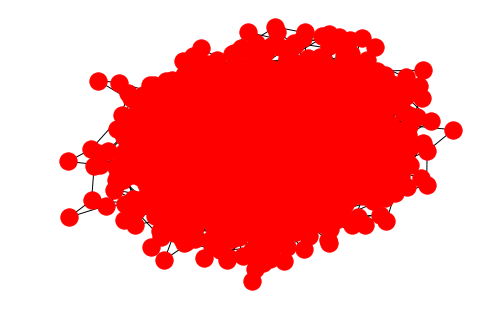

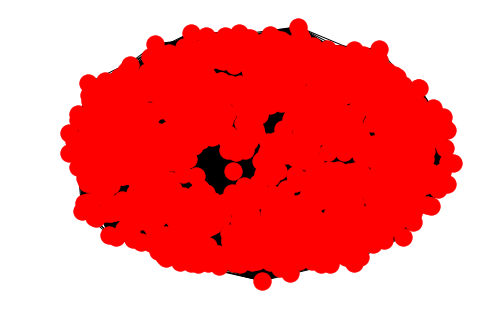

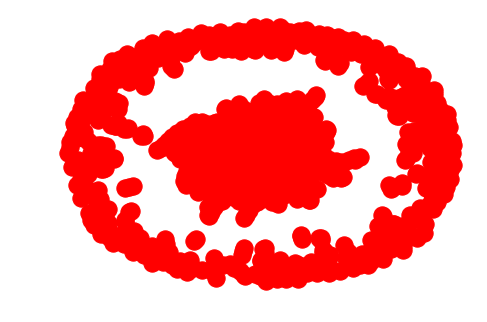

In [36]:

#small world
model=nx.watts_strogatz_graph(len(G.nodes),5,0.5)
nx.draw(model)
plt.show()

#random graph
model2=nx.gnp_random_graph(len(G.nodes),0.3)#random graph given number of nodes and probability of edge creation
nx.draw(model2)
plt.show()

model3=nx.gnm_random_graph(len(G.nodes),len(G.edges))#random graph given number of nodes and number of edges
nx.draw(model3)
plt.show()

